In [1]:
!pip install dtw
!pip install basemap

ERROR: Operation cancelled by user


In [2]:
import pandas as pd
import mpl_toolkits.basemap
from mpl_toolkits.basemap import Basemap
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from dtw import accelerated_dtw
from scipy.spatial.distance import euclidean
from sklearn.metrics import silhouette_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [3]:
flight_data= pd.read_csv('/content/airports.csv')
flight_data.head()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"40.07080078125, -74.93360137939453"
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"38.704022, -101.473911"
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"59.947733, -151.692524"
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"34.86479949951172, -86.77030181884766"
4,00AN,small_airport,Katmai Lodge Airport,80.0,NaN,US,US-AK,King Salmon,00AN,NaN,00AN,"59.093287, -156.456699"


In [4]:
# Separate the coordinates into latitude and longitude
coordinates = flight_data['coordinates'].str.split(',', expand=True)
flight_data['latitude'] = coordinates[0].astype(float)
flight_data['longitude'] = coordinates[1].astype(float)

# Drop the original coordinates column
flight_data.drop(columns=['coordinates'], inplace=True)

# Handle missing values
flight_data.fillna(method='ffill', inplace=True)  # Forward fill to handle any missing values

# Replace any infinite values with large finite numbers
flight_data.replace([np.inf, -np.inf], np.nan, inplace=True)
flight_data.fillna(method='ffill', inplace=True)  # Forward fill again to handle infinite values

# Display the updated dataset
flight_data.head()


<ipython-input-4-edd1627a4ed6>:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  flight_data.fillna(method='ffill', inplace=True)  # Forward fill to handle any missing values
<ipython-input-4-edd1627a4ed6>:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  flight_data.fillna(method='ffill', inplace=True)  # Forward fill again to handle infinite values


,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,latitude,longitude
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,40.070801,-74.933601
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,38.704022,-101.473911
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,59.947733,-151.692524
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,34.864799,-86.770302
4,00AN,small_airport,Katmai Lodge Airport,80.0,NaN,US,US-AK,King Salmon,00AN,NaN,00AN,59.093287,-156.456699


In [5]:
# Function to create a linear trajectory between two airports
def create_trajectory(start, end, num_points=10):
    latitudes = np.linspace(start[0], end[0], num=num_points)
    longitudes = np.linspace(start[1], end[1], num=num_points)
    return np.vstack((latitudes, longitudes)).T

In [6]:
# Select random pairs of airports to create trajectories
num_trajectories = 100
trajectory_length = 10  # Number of points in each trajectory

trajectories = []
for _ in range(num_trajectories):
    start_airport = flight_data.sample(1)[['latitude', 'longitude']].values[0]
    end_airport = flight_data.sample(1)[['latitude', 'longitude']].values[0]
    trajectory = create_trajectory(start_airport, end_airport, num_points=trajectory_length)
    trajectories.append(trajectory)

# Convert trajectories to numpy array for further processing
trajectories = np.array(trajectories)

# Display the shape of the trajectory data
trajectories.shape  # Should be (100, 10, 2) - 100 trajectories, each with 10 points (latitude, longitude)

(100, 10, 2)

In [7]:
# Compute DTW distance matrix for trajectories
def dtw_distance_matrix(trajectories):
    n = len(trajectories)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            dist, _, _, _ = accelerated_dtw(trajectories[i], trajectories[j], dist=euclidean)
            dist_matrix[i, j] = dist
            dist_matrix[j, i] = dist
    return dist_matrix

# Calculate the DTW matrix for the trajectories
dtw_matrix = dtw_distance_matrix(trajectories)

In [8]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import seaborn as sns

In [9]:
# Apply K-means clustering
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(dtw_matrix)

# Evaluate the clusters using silhouette score
kmeans_silhouette = silhouette_score(dtw_matrix, kmeans_labels, metric='precomputed')
print(f'K-means Silhouette Score: {kmeans_silhouette}')


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


K-means Silhouette Score: 0.39117328167724025


In [10]:
# Apply DBSCAN clustering
dbscan = DBSCAN(eps=10, min_samples=5, metric='precomputed')
dbscan_labels = dbscan.fit_predict(dtw_matrix)

# Check the number of unique labels
n_clusters_dbscan = len(np.unique(dbscan_labels))
print("Number of DBSCAN clusters:", n_clusters_dbscan)

# Calculate Silhouette Score only if more than one cluster is found
if n_clusters_dbscan > 1:
    dbscan_silhouette = silhouette_score(dtw_matrix, dbscan_labels, metric='precomputed')
    print(f'DBSCAN Silhouette Score: {dbscan_silhouette}')
else:
    print("Silhouette Score cannot be calculated for DBSCAN as only one cluster was found.")

Number of DBSCAN clusters: 1
Silhouette Score cannot be calculated for DBSCAN as only one cluster was found.


In [11]:
# Apply Hierarchical (Agglomerative) clustering
hierarchical = AgglomerativeClustering(n_clusters=num_clusters, affinity='precomputed', linkage='complete')
hierarchical_labels = hierarchical.fit_predict(dtw_matrix)

#Evaluate the clusters using silhouette score
hierarchical_silhouette = silhouette_score(dtw_matrix, hierarchical_labels, metric='precomputed')
print(f'Hierarchical Silhouette Score: {hierarchical_silhouette}')

Hierarchical Silhouette Score: 0.4536633910175749


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [12]:
# Visualization of clusters
def plot_clusters(trajectories, labels, title):
    plt.figure(figsize=(10, 6))
    unique_labels = np.unique(labels)
    for label in unique_labels:
        if label == -1:  # DBSCAN noise points
            continue
        for trajectory in trajectories[labels == label]:
            plt.plot(trajectory[:, 0], trajectory[:, 1], alpha=0.3)
    plt.title(title)
    plt.show()

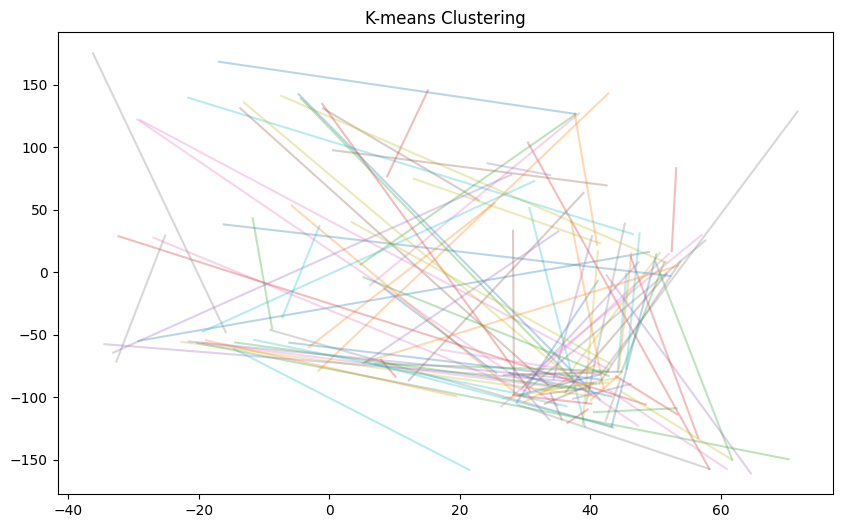

In [13]:
plot_clusters(trajectories, kmeans_labels, 'K-means Clustering')

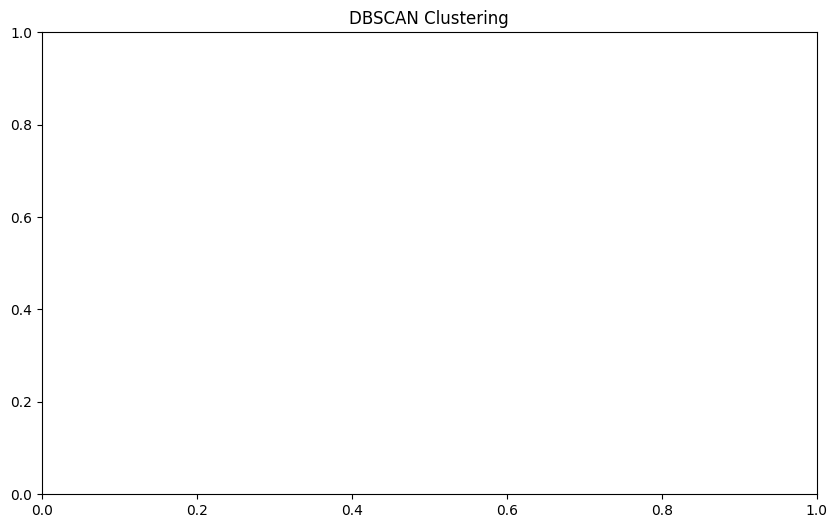

In [14]:
plot_clusters(trajectories, dbscan_labels, 'DBSCAN Clustering')

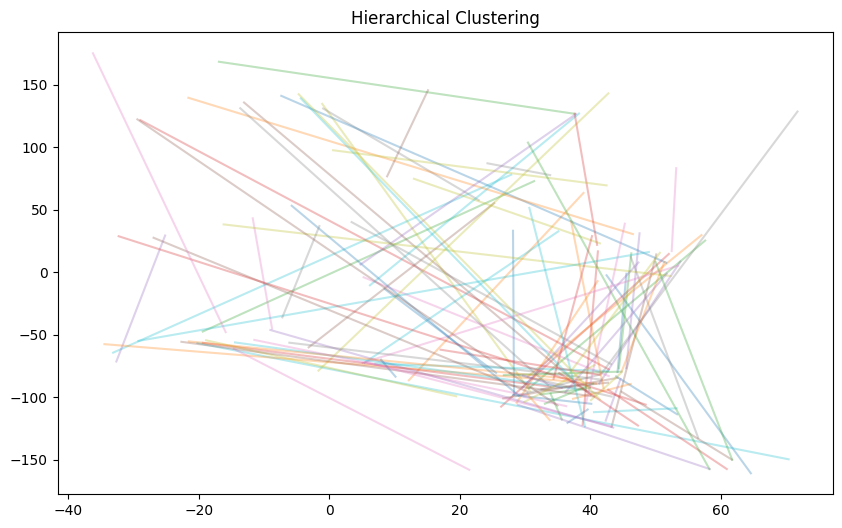

In [15]:
plot_clusters(trajectories, hierarchical_labels, 'Hierarchical Clustering')

In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed
from sklearn.preprocessing import StandardScaler

# Standardize the trajectory data
scaler = StandardScaler()
trajectories_flat = trajectories.reshape(trajectories.shape[0], -1)
trajectories_scaled = scaler.fit_transform(trajectories_flat)

# Define the autoencoder model
input_dim = trajectories_scaled.shape[1]
encoding_dim = 10  # Dimension of the latent space

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="relu")(input_layer)
decoder = Dense(input_dim, activation="sigmoid")(encoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(trajectories_scaled, trajectories_scaled, epochs=50, batch_size=16, shuffle=True, validation_split=0.2)

# Extract the encoder part to reduce dimensionality
encoder_model = Model(inputs=input_layer, outputs=encoder)
encoded_trajectories = encoder_model.predict(trajectories_scaled)

# Apply clustering in the latent space
kmeans_latent = KMeans(n_clusters=num_clusters, random_state=42)
latent_labels = kmeans_latent.fit_predict(encoded_trajectories)

# Evaluate the latent space clusters using silhouette score
latent_silhouette = silhouette_score(encoded_trajectories, latent_labels)
print(f'Latent Space K-means Silhouette Score: {latent_silhouette}')



Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 1.3506 - val_loss: 0.7857
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.3872 - val_loss: 0.7798
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.3165 - val_loss: 0.7741
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.3112 - val_loss: 0.7685
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 1.2342 - val_loss: 0.7629
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 1.2706 - val_loss: 0.7573
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.4298 - val_loss: 0.7515
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.2734 - val_loss: 0.7457
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.2485 - val_loss: 0.7398
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.2223 - val_loss: 0.7338
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.2545 - val_loss: 0.7277
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1.2086 - val_loss: 0.7213
E

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


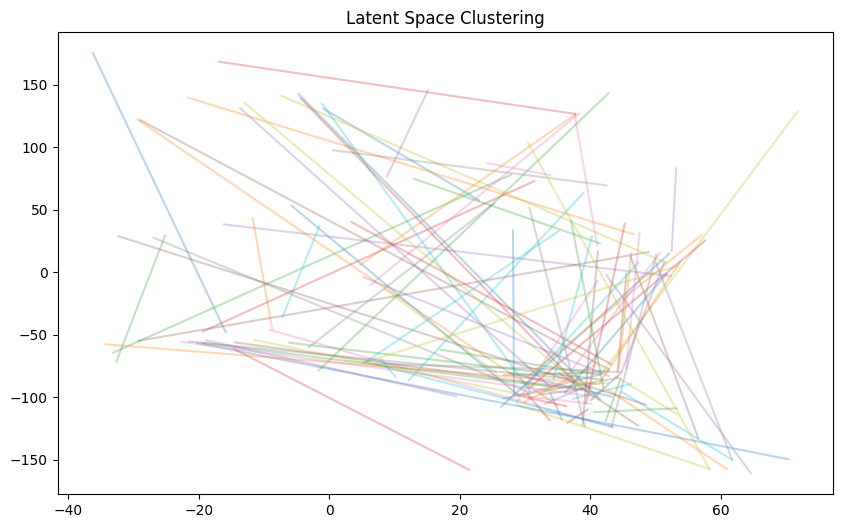

In [17]:
# Visualization of latent space clusters
plot_clusters(trajectories, latent_labels, 'Latent Space Clustering')

In [18]:
# Function to plot clusters on a 2D map (latitude vs. longitude)
def plot_map_clusters(trajectories, labels, title):
    plt.figure(figsize=(12, 8))
    unique_labels = np.unique(labels)
    for label in unique_labels:
        if label == -1:  # DBSCAN noise points
            continue
        cluster_points = np.vstack(trajectories[labels == label])
        plt.scatter(cluster_points[:, 1], cluster_points[:, 0], label=f'Cluster {label}', alpha=0.5)
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()

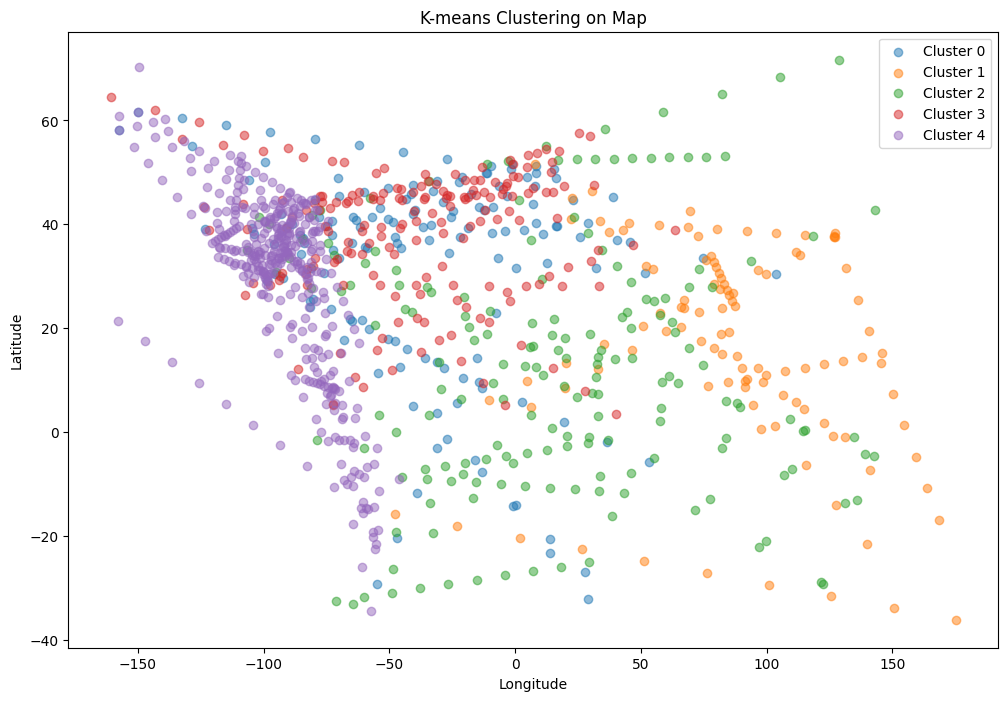

In [19]:
# Plot K-means clustering results
plot_map_clusters(trajectories, kmeans_labels, 'K-means Clustering on Map')


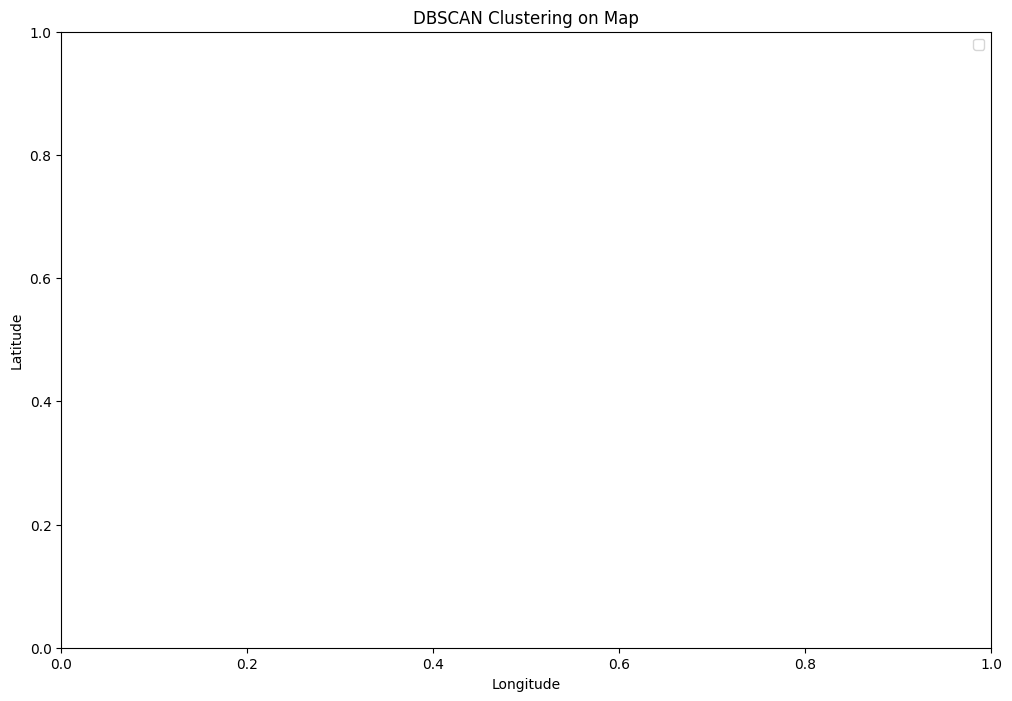

In [20]:
# Plot DBSCAN clustering results
plot_map_clusters(trajectories, dbscan_labels, 'DBSCAN Clustering on Map')


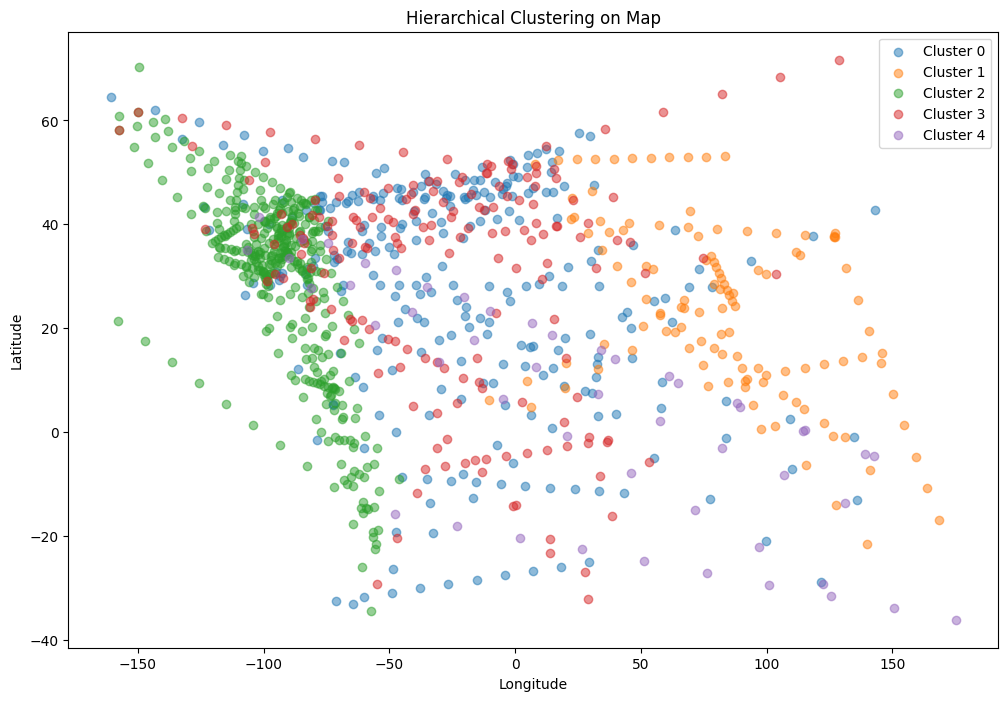

In [21]:
# Plot Hierarchical clustering results
plot_map_clusters(trajectories, hierarchical_labels, 'Hierarchical Clustering on Map')


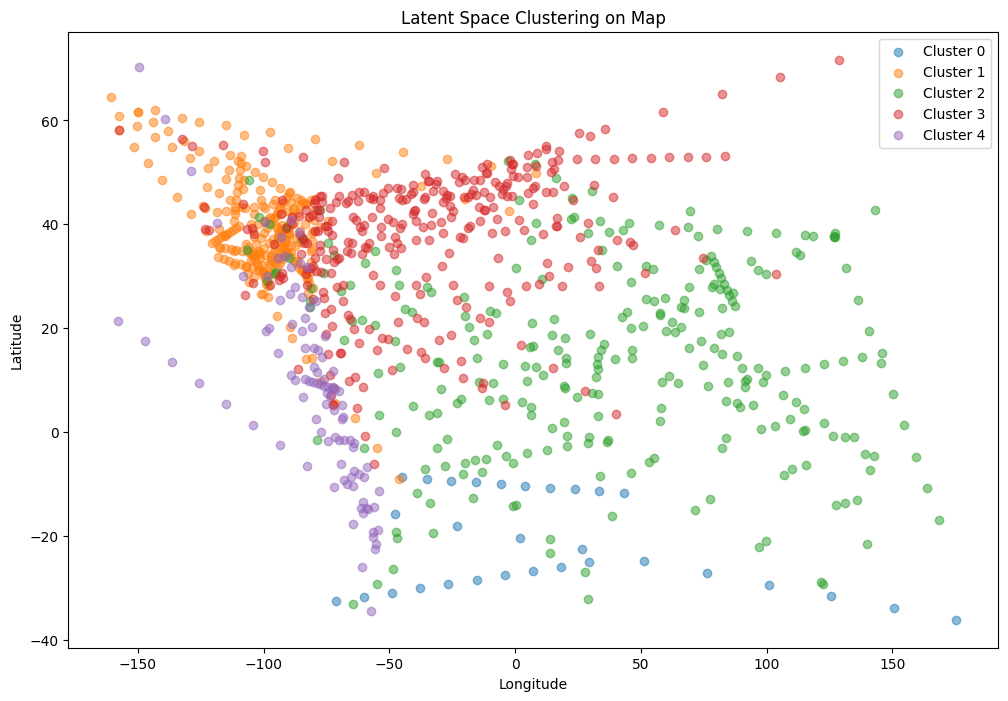

In [22]:
# Plot Latent space clustering results
plot_map_clusters(trajectories, latent_labels, 'Latent Space Clustering on Map')

<ipython-input-23-5cb2042f00ab>:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))  # Ensures enough distinct colors


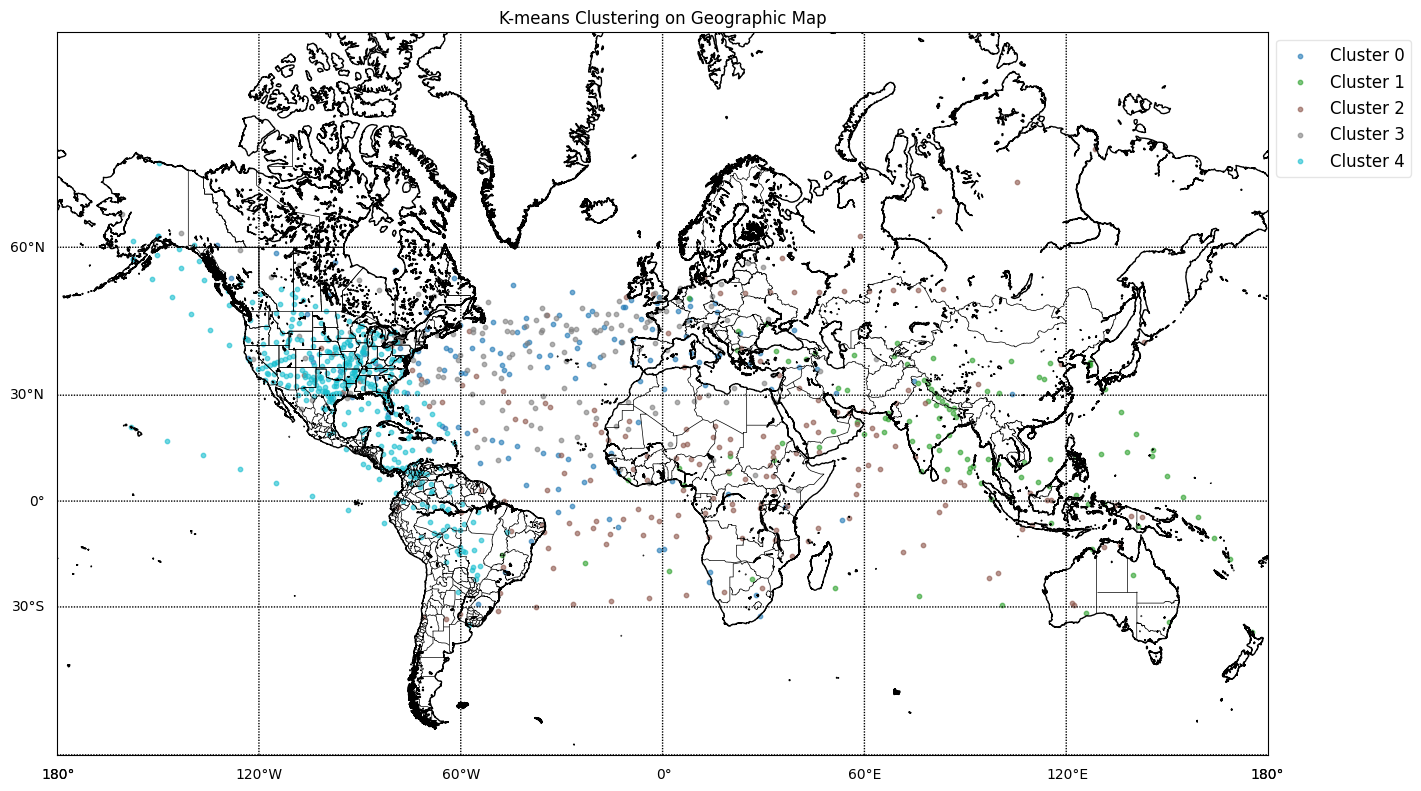

In [23]:
def plot_map_clusters_basemap(trajectories, labels, title):
    plt.figure(figsize=(14, 8))  # Adjusted to a 16:9 ratio

    # Set up the basemap with a more proportional bounding box
    m = Basemap(projection='merc', llcrnrlat=-60, urcrnrlat=80, llcrnrlon=-180, urcrnrlon=180, resolution='i')
    m.drawcoastlines()
    m.drawcountries()
    m.drawstates()

    # Draw parallels and meridians
    m.drawparallels(np.arange(-60.,81.,30.), labels=[True,False,False,False], fontsize=10)
    m.drawmeridians(np.arange(-180.,181.,60.), labels=[False,False,False,True], fontsize=10)

    unique_labels = np.unique(labels)
    colors = plt.cm.get_cmap('tab10', len(unique_labels))  # Ensures enough distinct colors

    for label in unique_labels:
        if label == -1:  # DBSCAN noise points, if applicable
            continue
        cluster_points = np.vstack(trajectories[labels == label])
        x, y = m(cluster_points[:, 1], cluster_points[:, 0])  # Longitude first for Basemap
        m.scatter(x, y, label=f'Cluster {label}', alpha=0.6, s=10, color=colors(label))

    plt.title(title)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12, framealpha=0.5)  # Positioned outside the map
    plt.tight_layout()
    plt.show()

# Plot K-means clustering results on a Basemap
plot_map_clusters_basemap(trajectories, kmeans_labels, 'K-means Clustering on Geographic Map')

In [24]:
 #Hyperparameter Tuning
 # Define the range of n_clusters to try
cluster_range = range(2, 11)
silhouette_scores = []

# Loop over different values of n_clusters
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(dtw_matrix)

    # Calculate the silhouette score for each n_clusters
    score = silhouette_score(dtw_matrix, kmeans_labels, metric='precomputed')
    silhouette_scores.append(score)
    print(f'n_clusters = {n_clusters}, Silhouette Score = {score}')


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

n_clusters = 2, Silhouette Score = 0.47139698992007256
n_clusters = 3, Silhouette Score = 0.3642779280736132
n_clusters = 4, Silhouette Score = 0.48157744147450443
n_clusters = 5, Silhouette Score = 0.39117328167724025
n_clusters = 6, Silhouette Score = 0.44554203663172204
n_clusters = 7, Silhouette Score = 0.4360988320424724
n_clusters = 8, Silhouette Score = 0.3284360015188204
n_clusters = 9, Silhouette Score = 0.3635488459807073
n_clusters = 10, Silhouette Score = 0.3681103314401827


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

In [25]:
# Find the optimal number of clusters
optimal_index = np.argmax(silhouette_scores)
optimal_n_clusters = cluster_range[optimal_index]
optimal_score = silhouette_scores[optimal_index]

print(f'Optimal number of clusters: {optimal_n_clusters}, with a Silhouette Score of: {optimal_score}')

Optimal number of clusters: 4, with a Silhouette Score of: 0.48157744147450443


In [26]:
# Define the range for eps and min_samples
eps_range = np.arange(0.1, 1.0, 0.1)
min_samples_range = range(2, 10)
best_score = -1
best_params = {}

# Loop over different values of eps and min_samples
for eps in eps_range:
    for min_samples in min_samples_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
        dbscan_labels = dbscan.fit_predict(dtw_matrix)

        # Only compute silhouette score if there are more than 1 cluster
        if len(set(dbscan_labels)) > 1:
            score = silhouette_score(dtw_matrix, dbscan_labels, metric='precomputed')
            if score > best_score:
                best_score = score
                best_params = {'eps': eps, 'min_samples': min_samples}
            print(f'eps = {eps}, min_samples = {min_samples}, Silhouette Score = {score}')

print(f'Best DBSCAN parameters: {best_params}, Best Silhouette Score: {best_score}')

Best DBSCAN parameters: {}, Best Silhouette Score: -1


In [27]:
# Define the range of n_clusters and linkage methods
cluster_range = range(2, 11)
linkage_methods = ['complete', 'average', 'single']  # Removed 'ward'
best_score = -1
best_params = {}

# Loop over different values of n_clusters and linkage methods
for n_clusters in cluster_range:
    for linkage in linkage_methods:
        hierarchical = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage=linkage)
        hierarchical_labels = hierarchical.fit_predict(dtw_matrix)

        score = silhouette_score(dtw_matrix, hierarchical_labels, metric='precomputed')
        if score > best_score:
            best_score = score
            best_params = {'n_clusters': n_clusters, 'linkage': linkage}
        print(f'n_clusters = {n_clusters}, linkage = {linkage}, Silhouette Score = {score}')


n_clusters = 2, linkage = complete, Silhouette Score = 0.4832880961854975
n_clusters = 2, linkage = average, Silhouette Score = 0.46938354898392026
n_clusters = 2, linkage = single, Silhouette Score = 0.48353483560272437
n_clusters = 3, linkage = complete, Silhouette Score = 0.3685479744189993
n_clusters = 3, linkage = average, Silhouette Score = 0.36197927494374
n_clusters = 3, linkage = single, Silhouette Score = 0.30573522201943354
n_clusters = 4, linkage = complete, Silhouette Score = 0.45866123965577776
n_clusters = 4, linkage = average, Silhouette Score = 0.48425644974797216
n_clusters = 4, linkage = single, Silhouette Score = 0.3892232393312234
n_clusters = 5, linkage = complete, Silhouette Score = 0.4536633910175749
n_clusters = 5, linkage = average, Silhouette Score = 0.4601751647925951
n_clusters = 5, linkage = single, Silhouette Score = 0.24255954670163785
n_clusters = 6, linkage = complete, Silhouette Score = 0.44901606812986294
n_clusters = 6, linkage = average, Silhouette

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and wi

In [28]:
print(f'Best Hierarchical parameters: {best_params}, Best Silhouette Score: {best_score}')

Best Hierarchical parameters: {'n_clusters': 4, 'linkage': 'average'}, Best Silhouette Score: 0.48425644974797216


In [29]:
#Tuning Deep Learning-Based Clustering
# Function to train autoencoder and perform clustering
def train_autoencoder(latent_dim):
    input_layer = Input(shape=(input_dim,))
    encoder = Dense(latent_dim, activation="relu")(input_layer)
    decoder = Dense(input_dim, activation="sigmoid")(encoder)

    autoencoder = Model(inputs=input_layer, outputs=decoder)
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.fit(trajectories_scaled, trajectories_scaled, epochs=50, batch_size=16, shuffle=True, validation_split=0.2)

    # Extract the encoder part
    encoder_model = Model(inputs=input_layer, outputs=encoder)
    encoded_trajectories = encoder_model.predict(trajectories_scaled)

    # Perform clustering in the latent space
    kmeans_latent = KMeans(n_clusters=num_clusters, random_state=42)
    latent_labels = kmeans_latent.fit_predict(encoded_trajectories)

    # Evaluate the clustering using silhouette score
    latent_silhouette = silhouette_score(encoded_trajectories, latent_labels)
    return latent_silhouette

# Tune the latent dimension
latent_dims = [5, 10, 15, 20]
best_score = -1
best_dim = 0

for dim in latent_dims:
    score = train_autoencoder(dim)
    print(f'Latent Dimension: {dim}, Silhouette Score: {score}')
    if score > best_score:
        best_score = score
        best_dim = dim


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 1.3572 - val_loss: 0.8094
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3970 - val_loss: 0.8045
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3846 - val_loss: 0.7997
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3571 - val_loss: 0.7950
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3732 - val_loss: 0.7906
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.4021 - val_loss: 0.7865
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3628 - val_loss: 0.7825
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2888 - val_loss: 0.7787
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2785 - val_loss: 0.7749
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3312 - val_loss: 0.7712
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2678 - val_loss: 0.7677
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.3229 - val_loss: 0.7642
Epoch 13

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 1.3662 - val_loss: 0.8041
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.3422 - val_loss: 0.7941
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3825 - val_loss: 0.7844
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.2206 - val_loss: 0.7753
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3806 - val_loss: 0.7664
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.3712 - val_loss: 0.7578
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2464 - val_loss: 0.7495
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3469 - val_loss: 0.7417
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.2909 - val_loss: 0.7343
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1664 - val_loss: 0.7272
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1801 - val_loss: 0.7203
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.2554 - val_loss: 0.7139
Epoch 13/50
5/5

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Latent Dimension: 10, Silhouette Score: 0.3982378840446472
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 1.4958 - val_loss: 0.7642
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2605 - val_loss: 0.7555
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.2909 - val_loss: 0.7470
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2358 - val_loss: 0.7387
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1910 - val_loss: 0.7304
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3016 - val_loss: 0.7221
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2963 - val_loss: 0.7138
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.1500 - val_loss: 0.7051
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.2645 - val_loss: 0.6964
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3058 - val_loss: 0.6876
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.0694 - val_loss: 0.6787
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1016 - val_loss: 0.6695
Epoch 13/50
5/5

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 1.4163 - val_loss: 0.7950
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.4312 - val_loss: 0.7789
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.3630 - val_loss: 0.7636
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2829 - val_loss: 0.7491
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3049 - val_loss: 0.7346
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2733 - val_loss: 0.7208
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3542 - val_loss: 0.7071
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.4002 - val_loss: 0.6938
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.2387 - val_loss: 0.6811
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.2607 - val_loss: 0.6683
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.1390 - val_loss: 0.6557
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.1690 - val_loss: 0.6430
Epoch 13/50
5/5 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [30]:
print(f'Best Latent Dimension: {best_dim}, Best Silhouette Score: {best_score}')

Best Latent Dimension: 5, Best Silhouette Score: 0.5121036767959595


In [31]:
# Assuming 'dtw_matrix' is your precomputed distance matrix
hierarchical1 = AgglomerativeClustering(n_clusters=2, affinity='precomputed', linkage='average')
cluster_assignments = hierarchical1.fit_predict(dtw_matrix)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


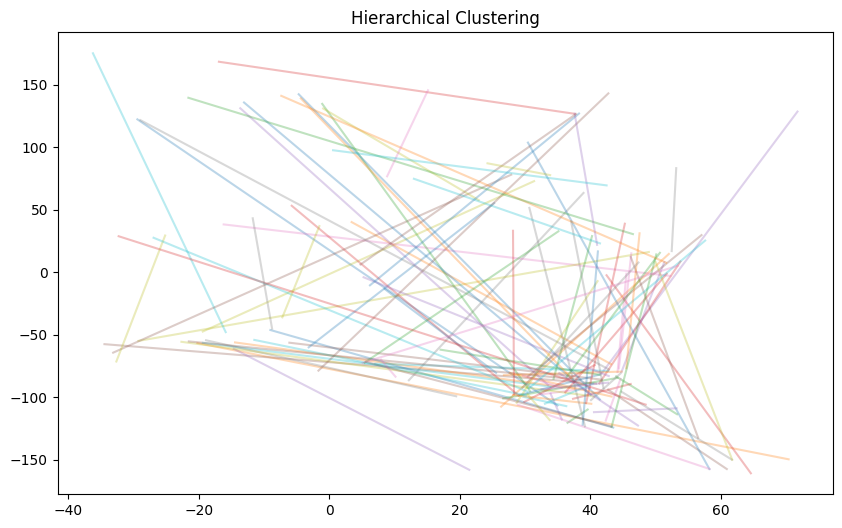

In [32]:
plot_clusters(trajectories, cluster_assignments, 'Hierarchical Clustering')

In [33]:
from sklearn.model_selection import train_test_split

# Prepare sequences for LSTM based on hierarchical clustering
sequence_length = 4  # Lookback period for prediction
X, Y, cluster_labels = [], [], []

# Loop through each trajectory and create sequences
for i, trajectory in enumerate(trajectories):
    for j in range(len(trajectory) - sequence_length):
        X.append(trajectory[j:j + sequence_length])
        Y.append(trajectory[j + sequence_length])
        # Append the corresponding cluster assignment for this sequence
        cluster_labels.append(cluster_assignments[i])

X = np.array(X)
Y = np.array(Y)
cluster_labels = np.array(cluster_labels) # Convert to numpy array

# Perform a train-test split, stratifying by cluster assignments from hierarchical clustering
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=cluster_labels
)

In [34]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=2))  # Predicting latitude and longitude

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_data=(X_test, Y_test), verbose=1)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 3739.2107 - val_loss: 3207.0964
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3465.2097 - val_loss: 3046.8181
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3160.8381 - val_loss: 2865.8938
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3171.3303 - val_loss: 2725.9839
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3004.4983 - val_loss: 2629.4871
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2971.0681 - val_loss: 2549.8894
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2764.3860 - val_loss: 2476.2317
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2656.1084 - val_loss: 2406.6975
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2669.1187 - val_loss: 2341.4460
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2558.1321 - val_loss: 2278.3750
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2533.7212 - val_loss: 2221.4729
Epoch 12/20
15/15

In [35]:
# Make predictions on the test set
Y_pred_lstm = model.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step


In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate regression metrics
mse = mean_squared_error(Y_test, Y_pred_lstm)
mae = mean_absolute_error(Y_test, Y_pred_lstm)
r2 = r2_score(Y_test, Y_pred_lstm)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-Squared: {r2}')


Mean Squared Error: 1821.3421901157212
Mean Absolute Error: 33.31181302749361
R-Squared: 0.0200367430965262


In [38]:
from sklearn.metrics import confusion_matrix, classification_report

# Discretize regions to the predictions
def discretize_coordinates(y):
    # Example discretization logic: assign to one of two regions based on longitude
    if y[1] < 0: # Assuming y[1] is the longitude
        return 0  # Region 0
    else:
        return 1  # Region 1

Y_test_discrete = np.apply_along_axis(discretize_coordinates, 1, Y_test)
Y_pred_discrete = np.apply_along_axis(discretize_coordinates, 1, Y_pred_lstm)

# Compute the confusion matrix
conf_matrix = confusion_matrix(Y_test_discrete, Y_pred_discrete)
print(conf_matrix)

# Display a classification report
print(classification_report(Y_test_discrete, Y_pred_discrete))

[[92  0]
 [ 2 26]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        92
           1       1.00      0.93      0.96        28

    accuracy                           0.98       120
   macro avg       0.99      0.96      0.98       120
weighted avg       0.98      0.98      0.98       120



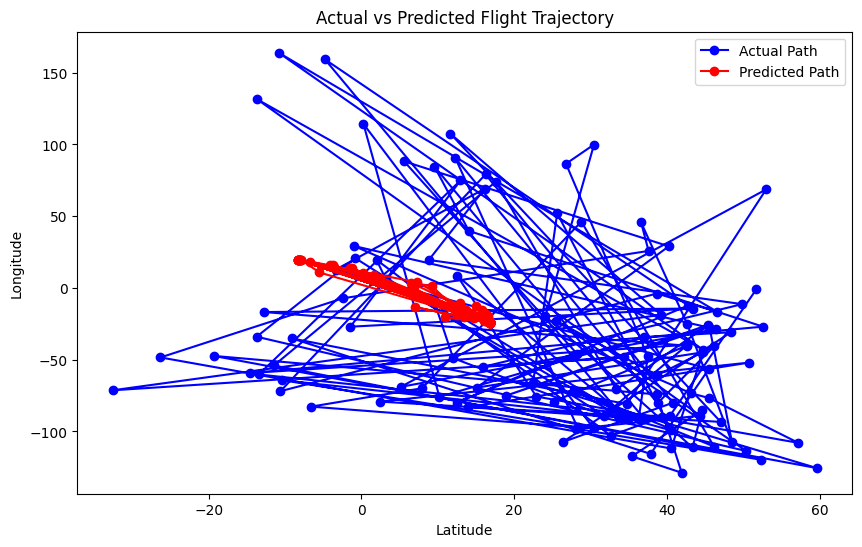

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(Y_test[:, 0], Y_test[:, 1], 'bo-', label="Actual Path")
plt.plot(Y_pred_lstm[:, 0], Y_pred_lstm[:, 1], 'ro-', label="Predicted Path")
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Actual vs Predicted Flight Trajectory')
plt.legend()
plt.show()


In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten

# Build the CNN-LSTM model
model_cnn = Sequential()

# Add the CNN layers
model_cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(sequence_length, X_train.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())

# Add the LSTM layers
model_cnn.add(RepeatVector(sequence_length))
model_cnn.add(LSTM(units=50, return_sequences=True))
model_cnn.add(Dropout(0.2))
model_cnn.add(LSTM(units=50))
model_cnn.add(Dropout(0.2))

# Add the output layer
model_cnn.add(Dense(units=2))  # Predicting latitude and longitude

# Compile the model
model_cnn.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
cnn_history = model_cnn.fit(X_train, Y_train, epochs=20, batch_size=32, validation_data=(X_test, Y_test), verbose=1)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 3780.7654 - val_loss: 3143.8350
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3506.0928 - val_loss: 2922.3506
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3223.1582 - val_loss: 2739.8594
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3042.2817 - val_loss: 2611.1013
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2982.3689 - val_loss: 2523.8174
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2818.0173 - val_loss: 2451.7590
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2640.9414 - val_loss: 2386.7585
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2649.0337 - val_loss: 2329.7983
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2593.1631 - val_loss: 2278.1711
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2471.3757 - val_loss: 2227.1750
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2397.9011 - val_loss: 2178.2312
Epoch 12

In [41]:
# Make predictions on the test set
Y_pred_cnn = model_cnn.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


In [42]:
from sklearn.metrics import confusion_matrix, classification_report

# Discretize regions to the predictions
# Define your discretization logic here:
def discretize_coordinates(y):

    # Placeholder implementation:
    return int(y[0] // 5), int(y[1] // 5)

Y_test_discrete = np.apply_along_axis(discretize_coordinates, 1, Y_test)
Y_pred_discrete_cnn = np.apply_along_axis(discretize_coordinates, 1, Y_pred_cnn)

# Compute the confusion matrix
conf_matrix_cnn = confusion_matrix(Y_test_discrete.flatten(), Y_pred_discrete_cnn.flatten())
print('Confusion Matrix:')
print(conf_matrix_cnn)

# Display a classification report (precision, recall, f1-score)
classification_report_str_cnn = classification_report(Y_test_discrete.flatten(), Y_pred_discrete_cnn.flatten())
print('Classification Report:')
print(classification_report_str_cnn)


Confusion Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Classification Report:
              precision    recall  f1-score   support

         -26       0.00      0.00      0.00         2
         -24       0.00      0.00      0.00         3
         -23       0.00      0.00      0.00         4
         -22       0.00      0.00      0.00         3
         -21       0.00      0.00      0.00         1
         -20       0.00      0.00      0.00         4
         -19       0.00      0.00      0.00         6
         -18       0.00      0.00      0.00         6
         -17       0.00      0.00      0.00         5
         -16       0.00      0.00      0.00         7
         -15       0.00      0.00      0.00         6
         -14       0.00      0.00      0.00         4
         -13       0.00      0.00      0.00         3
         -12       0.00      0.00      0.00         3
         -11       0.00     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


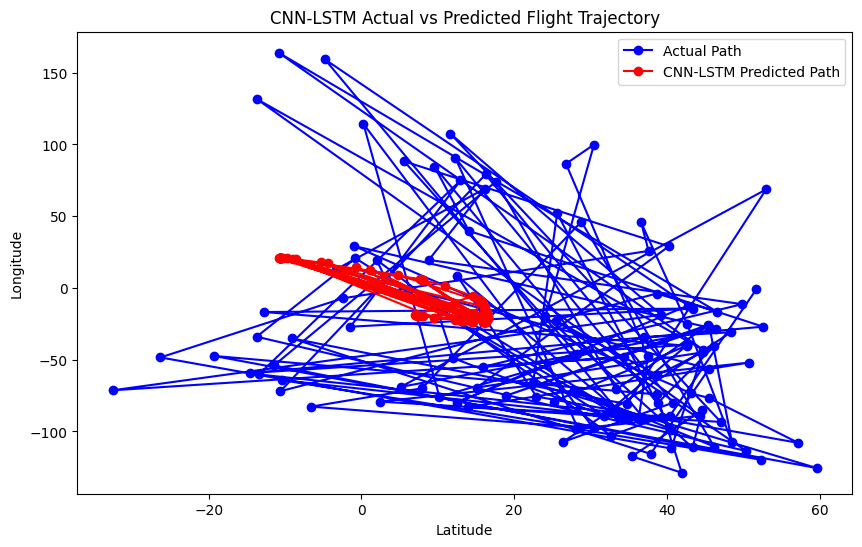

In [43]:
# Visualize CNN-LSTM predictions vs actual
plt.figure(figsize=(10, 6))
plt.plot(Y_test[:, 0], Y_test[:, 1], 'bo-', label="Actual Path")
plt.plot(Y_pred_cnn[:, 0], Y_pred_cnn[:, 1], 'ro-', label="CNN-LSTM Predicted Path")
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('CNN-LSTM Actual vs Predicted Flight Trajectory')
plt.legend()
plt.show()


In [44]:
# Define the weights for the ensemble
weight_lstm = 0.5
weight_cnn_lstm = 0.5

# Combine the predictions
Y_pred_ensemble = (weight_lstm * Y_pred_lstm) + (weight_cnn_lstm * Y_pred_cnn)


In [45]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate regression metrics for the ensemble predictions
mse_ensemble = mean_squared_error(Y_test, Y_pred_ensemble)
mae_ensemble = mean_absolute_error(Y_test, Y_pred_ensemble)
r2_ensemble = r2_score(Y_test, Y_pred_ensemble)

print(f'Ensemble Model Mean Squared Error: {mse_ensemble}')
print(f'Ensemble Model Mean Absolute Error: {mae_ensemble}')
print(f'Ensemble Model R-Squared: {r2_ensemble}')


Ensemble Model Mean Squared Error: 1812.7558849504583
Ensemble Model Mean Absolute Error: 33.14409625904056
Ensemble Model R-Squared: 0.02097250078867613


In [46]:
from sklearn.metrics import confusion_matrix, classification_report

# Discretize the ensemble predictions
Y_pred_ensemble_discrete = np.apply_along_axis(discretize_coordinates, 1, Y_pred_ensemble)

# Compute the confusion matrix
conf_matrix_ensemble = confusion_matrix(Y_test_discrete.flatten(), Y_pred_ensemble_discrete.flatten())
classification_report_ensemble = classification_report(Y_test_discrete.flatten(), Y_pred_ensemble_discrete.flatten())

print('Ensemble Confusion Matrix:')
print(conf_matrix_ensemble)
print('Ensemble Classification Report:')
print(classification_report_ensemble)


Ensemble Confusion Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Ensemble Classification Report:
              precision    recall  f1-score   support

         -26       0.00      0.00      0.00         2
         -24       0.00      0.00      0.00         3
         -23       0.00      0.00      0.00         4
         -22       0.00      0.00      0.00         3
         -21       0.00      0.00      0.00         1
         -20       0.00      0.00      0.00         4
         -19       0.00      0.00      0.00         6
         -18       0.00      0.00      0.00         6
         -17       0.00      0.00      0.00         5
         -16       0.00      0.00      0.00         7
         -15       0.00      0.00      0.00         6
         -14       0.00      0.00      0.00         4
         -13       0.00      0.00      0.00         3
         -12       0.00      0.00      0.00         3
         -

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
#Advanced Ensemble Techniques: Stacking
from sklearn.linear_model import LinearRegression

# Stack predictions as new features
stacked_predictions = np.hstack((Y_pred_lstm, Y_pred_cnn))

# Train a meta-learner (e.g., linear regression)
meta_learner = LinearRegression()
meta_learner.fit(stacked_predictions, Y_test)

# Make final predictions with the meta-learner
Y_pred_stacked = meta_learner.predict(stacked_predictions)

# Evaluate the stacked model
mse_stacked = mean_squared_error(Y_test, Y_pred_stacked)
mae_stacked = mean_absolute_error(Y_test, Y_pred_stacked)
r2_stacked = r2_score(Y_test, Y_pred_stacked)

print(f'Stacked Model Mean Squared Error: {mse_stacked}')
print(f'Stacked Model Mean Absolute Error: {mae_stacked}')
print(f'Stacked Model R-Squared: {r2_stacked}')


Stacked Model Mean Squared Error: 537.3936571902653
Stacked Model Mean Absolute Error: 18.467214324761166
Stacked Model R-Squared: 0.5600416805223476
